In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import uproot
import awkward as ak
from IPython.display import clear_output


filename = "/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6479/data18_13TeV.00348885.physics_Main.deriv.DAOD_PHYSLITE.r13286_p4910_p6479/DAOD_PHYSLITE.41578717._000256.pool.root.1"
compressed = "/eos/user/y/yolanney/compressedDAOD_PHYSLITE.pool.root"
# Load original
tree_orig = uproot.open({filename: "CollectionTree"})
el_pt_orig = tree_orig["AnalysisElectronsAuxDyn.pt"].array()
original = ak.flatten(el_pt_orig).to_numpy()

# Load compressed
tree_comp = uproot.open({compressed: "CollectionTree"})
el_pt_comp = tree_comp["AnalysisElectronsAuxDyn.pt"].array()
compressed = ak.flatten(el_pt_comp).to_numpy()

print(f'Original: {len(original):,} electrons')
print(f'Compressed: {len(compressed):,} electrons')

x_source = compressed.reshape(-1, 1)  # shape (N,1)
x_target = original.reshape(-1, 1)

# x_source_tensor = torch.tensor(x_source, dtype=torch.float32)
# x_target_tensor = torch.tensor(x_target, dtype=torch.float32)

# dataset = TensorDataset(x_source_tensor, x_target_tensor)
# dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


Original: 10,019 electrons
Compressed: 10,019 electrons


In [16]:
# Set percentile threshold for outlier removal (e.g., 99.9%)
pct_threshold = 99.9

# Compute thresholds on source and target separately
src_max = np.percentile(x_source, pct_threshold)
tgt_max = np.percentile(x_target, pct_threshold)

# Choose a shared max threshold (optional: take the min or max)
max_threshold = min(src_max, tgt_max)

# Filter data to remove outliers beyond max_threshold
mask = (x_source <= max_threshold) & (x_target <= max_threshold)

x_source_clean = x_source[mask]
x_target_clean = x_target[mask]

print(f"Removed {len(x_source) - len(x_source_clean)} outliers")

mean_src = x_source_clean.mean()
std_src = x_source_clean.std()

mean_tgt = x_target_clean.mean()
std_tgt = x_target_clean.std()

x_source_norm = (x_source_clean - mean_src) / std_src
x_target_norm = (x_target_clean - mean_tgt) / std_tgt


import torch
from torch.utils.data import TensorDataset, DataLoader

x_source_tensor = torch.tensor(x_source_norm.reshape(-1, 1), dtype=torch.float32)
x_target_tensor = torch.tensor(x_target_norm.reshape(-1, 1), dtype=torch.float32)

dataset = TensorDataset(x_source_tensor, x_target_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


Removed 11 outliers


In [17]:
class Autoencoder1D(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon


class VAE1D(nn.Module):
    def __init__(self, hidden_dim=32, latent_dim=8):
        super().__init__()
        # Encoder layers
        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)

        # Latent parameters
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # z ~ N(mu, sigma)

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return self.fc4(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    # KL divergence between posterior N(mu, σ^2) and N(0,1)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss.item(), kl_loss.item()


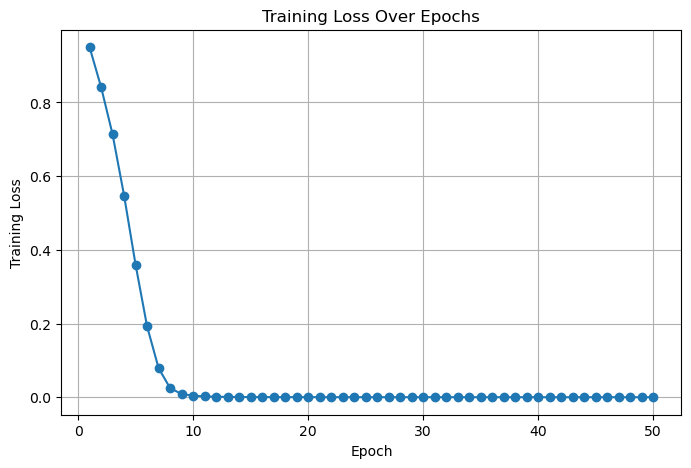

Epoch 50/50, Loss: 0.000021


In [18]:
model = Autoencoder1D()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

losses = []

n_epochs = 50
for epoch in range(n_epochs):
    total_loss = 0
    for x_src, x_tgt in dataloader:
        pred = model(x_src)
        loss = criterion(pred, x_tgt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(x_src)

    avg_loss = total_loss / len(dataset)
    losses.append(avg_loss)

    # Clear previous output and plot updated loss
    clear_output(wait=True)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}")

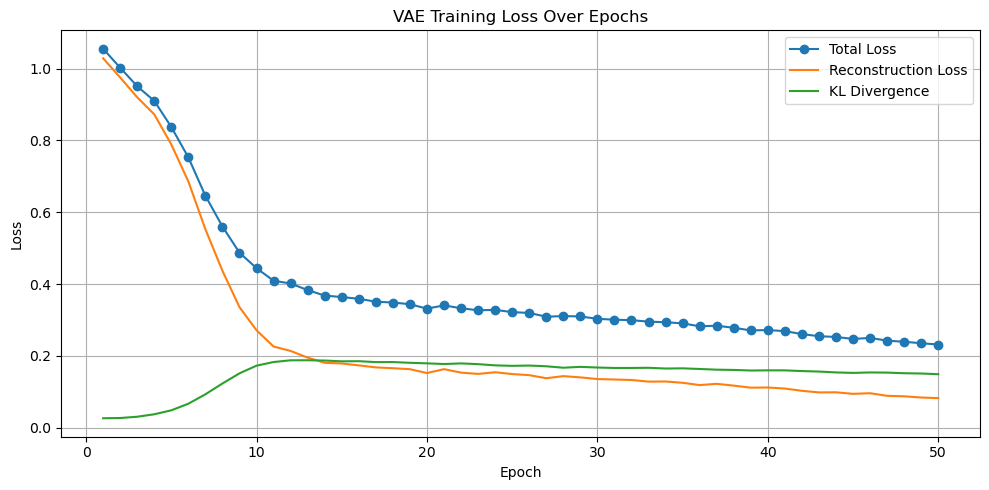

Epoch 50/50 | Total: 0.231826 | Recon: 0.082644 | KL: 0.149182


In [ ]:
model = VAE1D()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

losses = []
recon_losses = []
kl_losses = []

n_epochs = 50
for epoch in range(n_epochs):
    total_loss = 0
    total_recon = 0
    total_kl = 0

    for x_src, x_tgt in dataloader:
        recon, mu, logvar = model(x_src)
        loss, recon_l, kl_l = vae_loss_function(recon, x_tgt, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(x_src)
        total_recon += recon_l * len(x_src)
        total_kl += kl_l * len(x_src)

    avg_loss = total_loss / len(dataset)
    avg_recon = total_recon / len(dataset)
    avg_kl = total_kl / len(dataset)

    losses.append(avg_loss)
    recon_losses.append(avg_recon)
    kl_losses.append(avg_kl)

    # Live plotting
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(losses)+1), losses, label='Total Loss', marker='o')
    plt.plot(range(1, len(losses)+1), recon_losses, label='Reconstruction Loss')
    plt.plot(range(1, len(losses)+1), kl_losses, label='KL Divergence')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("VAE Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Epoch {epoch+1}/{n_epochs} | Total: {avg_loss:.6f} | Recon: {avg_recon:.6f} | KL: {avg_kl:.6f}")


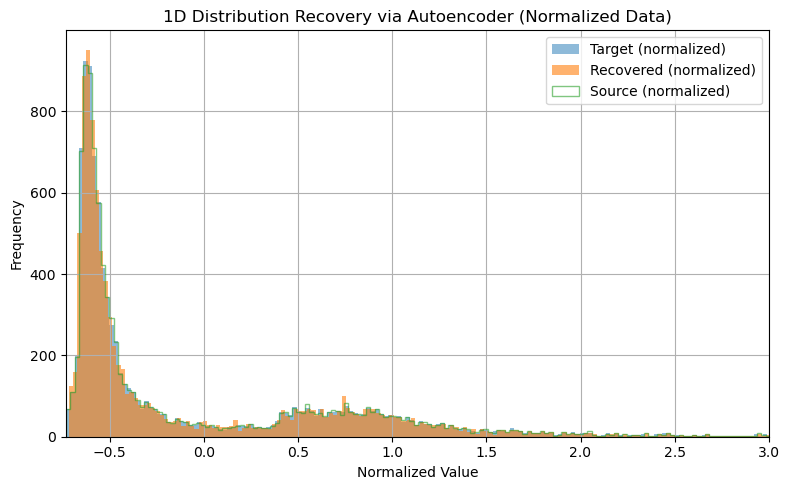

In [19]:
model.eval()
with torch.no_grad():
    recovered_norm = model(x_source_tensor)
recovered_norm = recovered_norm.numpy()

plt.figure(figsize=(8, 5))
plt.hist(x_target_norm, bins=500, alpha=0.5, label="Target (normalized)")
plt.hist(recovered_norm, bins=500, alpha=0.6, label="Recovered (normalized)")
plt.hist(x_source_norm, bins=500, alpha=0.6, label="Source (normalized)", histtype='step')
plt.legend()
plt.title("1D Distribution Recovery via Autoencoder (Normalized Data)")
plt.xlabel("Normalized Value")
plt.ylabel("Frequency")
# plt.xlim(x_target_norm.min(), x_target_norm.max())  # Adjust if needed, or use fixed like (-3, 3)
plt.xlim(x_target_norm.min(), 3)  # Adjust if needed, or use fixed like (-3, 3)

# plt.xlim(x_target_norm.min(), x_target_norm.max())  # Adjust if needed, or use fixed like (-3, 3)
plt.grid(True)
plt.tight_layout()
plt.show()
